# This script aims to prototype all parametrizations which are necessary for mechanical models

In [1]:
from lxml import etree as et
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('D:\\SMP_stability\\weac')
import weac as weac
caaml_ns = "{http://caaml.org/Schemas/SnowProfileIACS/v6.0.3}"

def mm2m(df):
    return(df/1000)

In [11]:
smp_deriv_file_path = '.pnt_data\\190110_BUN\\SMP\\FILE0245_smp_ful.pkl'  
layered_file_path = '.pnt_data\\190110_BUN\\SMP\\FILE0245_smp_lay.pkl' 

# read the SMP micromechanical properties from pickle

In [12]:
df_pkl = pd.read_pickle(smp_deriv_file_path)
df_pkl_layered = pd.read_pickle(layered_file_path)

In [13]:
from Emod_parametrizations import e_gerling_2017_AC
df_pkl_layered['G2017_E_AC'] = df_pkl_layered['CR2020_density'].apply(e_gerling_2017_AC) 

### Parametrizations from Johnson Schneebeli 1999 (Characterizing the microstructural and micromechanical properties of snow)

In [14]:
df_pkl_layered["JS1999_sigma_n"] = df_pkl_layered.L2012_f0 / (df_pkl_layered.L2012_L * df_pkl_layered.L2012_L) 
df_pkl_layered.JS1999_sigma_n.attr = "N/mm^2, MPa- Microstructural element compressive strength "
df_pkl_layered["JS1999_sigma_macro"] = df_pkl_layered.JS1999_sigma_n * (df_pkl_layered.L2012_delta / df_pkl_layered.L2012_L)
df_pkl_layered.JS1999_sigma_macro.attr = "N/mm^2, MPa - macroscale compressive strength"

### --> compute load of for each layer

In [15]:
layer_weight = df_pkl_layered.CR2020_density * mm2m(df_pkl_layered.thickness) # kg/m^2
layer_weight = layer_weight.cumsum().shift(1, fill_value=0) # adding up the weight and just taking the weights above
layer_weight = layer_weight * 9.81 # kg/m^2 * m/s^2 = N/m^2 = Pa
df_pkl_layered["load_above"] = layer_weight
df_pkl_layered.load_above.attrs['unit'] = "kg/m^2, Pa"

#  use weac to compute (skier) shear stress for each layer - (for bens index)
- configure the snowpack
- compute the stress at the height each layer
- compute skier stability index





### Define a slab profile as a 2D array where the columns are density (kg/m^2) and layer thickness (mm). One row corresponds to one layer counted from top (below surface) to bottom (above weak layer):

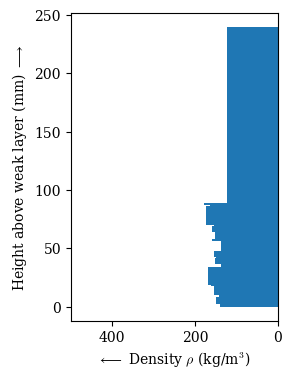

In [20]:
weak_layer_id = 19

density = df_pkl_layered["CR2020_density"].values
thickness = df_pkl_layered["thickness"].values
my_full_profile = np.column_stack((density, thickness))
# cut slab to the corresponding weak layer
myprofile = my_full_profile[:weak_layer_id,:].tolist()
# initializing the weac system profile
skier = weac.Layered(system='skier', layers=myprofile)
weac.plot.slab_profile(skier )

In [21]:
%%time
totallength = 1e4                       # Total length (mm)
cracklength = 300                        # Crack length (mm)
inclination = 38                        # Slope inclination (°)
skierweight = 80                        # Skier weigth (kg)

seg_skier = skier.calc_segments(L=totallength, a=cracklength, m=skierweight)['nocrack']

C_skier = skier.assemble_and_solve(phi=inclination, **seg_skier)
xsl_skier, z_skier, xwl_skier = skier.rasterize_solution(C=C_skier, phi=inclination, **seg_skier)

CPU times: total: 15.6 ms
Wall time: 23.9 ms


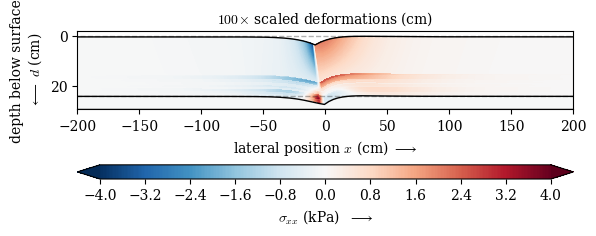

CPU times: total: 406 ms
Wall time: 408 ms


In [27]:
%%time
weac.plot.deformed(skier, xsl=xsl_skier, xwl=xwl_skier, z=z_skier,
                   phi=inclination, window=400, scale=100, aspect=2,
                   field='Sxx')

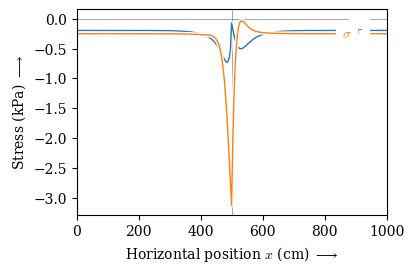

CPU times: total: 188 ms
Wall time: 190 ms


In [23]:
%%time
a = weac.plot.stresses(skier, x=xwl_skier, z=z_skier, **seg_skier)

0.24719999761063743
1.2706021172213084
CPU times: total: 15.6 ms
Wall time: 14 ms


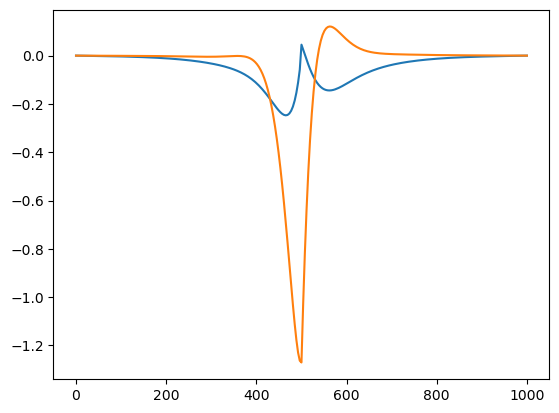

In [267]:
%%time
# compute maximum compressive and shear stress below skier (neglecting the weight of the slab)
x, tau = skier.get_weaklayer_shearstress(xwl_skier, z_skier, unit="kPa")
x, sig = skier.get_weaklayer_normalstress(xwl_skier, z_skier, unit="kPa")
tau_skier = tau-df_pkl_layered["load_above"][weak_layer_id]/1e3 * np.sin(np.deg2rad(inclination)) # remove the loading of the snowpack as in Reuter
sig_skier = sig-df_pkl_layered["load_above"][weak_layer_id]/1e3 * np.cos(np.deg2rad(inclination)) # remove the loading of the snowpack as in Reuter
plt.plot(x,tau_skier)
plt.plot(x,sig_skier)

max_tau_skier = max(abs(tau_skier))
max_sig_skier = max(abs(sig_skier))
print(max_tau_skier) # in kPa
print(max_sig_skier) # in kPa

### compute stress over strength

In [268]:
sig_strength = df_pkl_layered["JS1999_sigma_macro"][weak_layer_id]*1e3
S_reuter = sig_strength / max_tau_skier
S_reuter

66.36364846478541

In [269]:
max_tau_skier

0.24719999761063743

## compute S_reuter in short:

In [274]:
%%time
def compute_max_tau_with_weac(weak_layer_id):
    density = df_pkl_layered["CR2020_density"].values
    thickness = df_pkl_layered["thickness"].values
    slab_profile = np.column_stack((density, thickness))[:weak_layer_id, :].tolist()

    if len(slab_profile) == 0:
        return np.nan  # Handle empty slab profile case

    # Initialize the WEAC system profile
    skier = weac.Layered(system='skier', layers=slab_profile)
    seg_skier = skier.calc_segments(L=totallength, m=skierweight)['nocrack']
    C_skier = skier.assemble_and_solve(phi=inclination, **seg_skier)
    xsl_skier, z_skier, xwl_skier = skier.rasterize_solution(C=C_skier, phi=inclination, **seg_skier)
    x, tau = skier.get_weaklayer_shearstress(xwl_skier, z_skier, unit="kPa")

    # Compute tau_skier and max_tau_skier
    tau_skier = tau - df_pkl_layered["load_above"].iloc[weak_layer_id] / 1e3 * np.sin(np.deg2rad(inclination))
    return (max(abs(tau_skier)))

# Apply function to each row index
df_pkl_layered["max_tau_skier"] = df_pkl_layered.index.to_series().apply(compute_max_tau)
df_pkl_layered["S_Reuter2015"] = df_pkl_layered["JS1999_sigma_macro"]*1e3 / df_pkl_layered["max_tau_skier"]
df_pkl_layered["S_Reuter2015"]

CPU times: total: 328 ms
Wall time: 357 ms


layer_id
0              NaN
1        12.293071
2        11.659063
3        11.052505
4        11.366266
5         9.479645
6         8.034140
7        11.429132
8        10.750868
9        12.785605
10       13.863039
11       23.498084
12       18.048549
13       45.795917
14       66.420494
15       55.662814
16       38.136519
17       53.428471
18      931.630361
19    11058.485111
Name: S_Reuter2015, dtype: float64

### compute one rc for one layer:

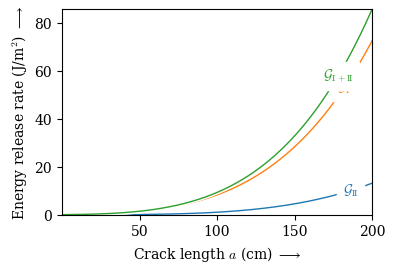

11.222444984168337


In [294]:
totallength = 4000                      # Total length (mm)
cracklength = 2000                      # Maximum crack length (mm)
inclination = 0                        # Slope inclination (°)
n = 500                               # Number of crack increments
weak_layer_id = 14

density = df_pkl_layered["CR2020_density"].values
thickness = df_pkl_layered["thickness"].values
slab_profile = np.column_stack((density, thickness))[:weak_layer_id, :].tolist()
# system
pst_cut_right = weac.Layered(system='pst-', layers=slab_profile)
seg_pst = pst_cut_right.calc_segments(L=totallength, a=cracklength)['nocrack']
C_pst = pst_cut_right.assemble_and_solve(phi=inclination, **seg_pst)
xsl_pst, z_pst, xwl_pst = pst_cut_right.rasterize_solution(C=C_pst, phi=inclination, **seg_pst)

# Initialize outputs and crack lengths
Gdif = np.zeros([3, n])
da = np.linspace(1e-6, cracklength, num=n)

# Loop through crack lengths
for i, a in enumerate(da):
    # Obtain lists of segment lengths, locations of foundations.
    seg_err = pst_cut_right.calc_segments(L=totallength, a=a)
    # Assemble system and solve for free constants
    C1 = pst_cut_right.assemble_and_solve(phi=inclination, **seg_err['crack']) 
    # Compute differential and incremental energy release rates
    Gdif[:, i] = pst_cut_right.gdif(C1, inclination, **seg_err['crack'])


weac.plot.err_modes(da, Gdif, kind='dif')
w_f = df_pkl_layered["R2015_wf"][weak_layer_id]
r_c = da[Gdif[0, :]*1000 > w_f].min()/10
print(r_c)

## compute for all possible layers

In [295]:
# Input
totallength = 4000                      # Total length (mm)
cracklength = 2000                      # Maximum crack length (mm)
inclination = 0                        # Slope inclination (°)
n = 500                               # Number of crack increments


# Initialize system:
# profile
for weak_layer_id in df_pkl_layered.index:
    density = df_pkl_layered["CR2020_density"].values
    thickness = df_pkl_layered["thickness"].values
    slab_profile = np.column_stack((density, thickness))[:weak_layer_id, :].tolist()
    # system
    pst_cut_right = weac.Layered(system='pst-', layers=slab_profile)
    seg_pst = pst_cut_right.calc_segments(L=totallength, a=cracklength)['nocrack']
    C_pst = pst_cut_right.assemble_and_solve(phi=inclination, **seg_pst)
    xsl_pst, z_pst, xwl_pst = pst_cut_right.rasterize_solution(C=C_pst, phi=inclination, **seg_pst)
    
    # Initialize outputs and crack lengths
    Gdif = np.zeros([3, n])
    da = np.linspace(1e-6, cracklength, num=n)
    
    # Loop through crack lengths
    for i, a in enumerate(da):
        # Obtain lists of segment lengths, locations of foundations.
        seg_err = pst_cut_right.calc_segments(L=totallength, a=a)
        # Assemble system and solve for free constants
        C1 = pst_cut_right.assemble_and_solve(phi=inclination, **seg_err['crack']) 
        # Compute differential and incremental energy release rates
        Gdif[:, i] = pst_cut_right.gdif(C1, inclination, **seg_err['crack'])
    
    
    #weac.plot.err_modes(da, Gdif, kind='dif')
    w_f = df_pkl_layered["R2015_wf"][weak_layer_id]
    r_c = da[Gdif[0, :]*1000 > w_f].min()/10
    print(r_c)

12.02404819018036
23.2464930743487
23.2464930743487
21.242485059318636
20.841683456312627
18.43687383827655
18.43687383827655
18.03607223527054
18.43687383827655
18.03607223527054
19.23847704428858
20.440881853306614
21.242485059318636
20.841683456312627
11.222444984168337
14.829659411222446
13.627254602204408
13.226452999198397
16.03206422024048
147.49499000621242
